In [1133]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt

In [1134]:
data = pd.read_excel('Salt.xls', index_col=[0, 1], names=['year', 'month', 'salt']).reset_index()

In [1135]:
data.month = data.month.map(
        {
            'январь': 1, 'февраль': 2, 'март': 3, 'апрель': 4, 'май': 5, 'июнь': 6,
            'июль': 7, 'август': 8, 'сентябрь': 9, 'октябрь': 10, 'ноябрь': 11, 'декабрь': 12
        }
    )
data['date'] = data['year'].astype(str) + '-' + data['month'].astype(str)
data.date = pd.to_datetime(data.date, format='%Y-%m')
data = data.drop(columns=['year', 'month']).set_index('date')

<Axes: xlabel='date'>

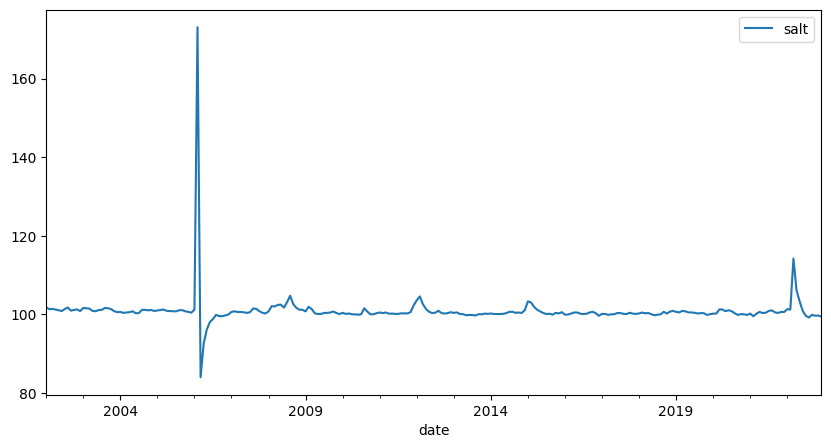

In [1136]:
data.plot(figsize=(10, 5))

In [1137]:
data.loc['2006-02-01':'2006-07-01', 'salt'] = np.nan
data.loc['2022-03-01':'2022-04-01', 'salt'] = np.nan

data.salt['2022']

date
2022-01-01    101.29
2022-02-01    101.18
2022-03-01       NaN
2022-04-01       NaN
2022-05-01    103.31
2022-06-01    100.86
2022-07-01     99.60
2022-08-01     99.17
2022-09-01     99.85
2022-10-01     99.62
2022-11-01     99.66
2022-12-01     99.43
Name: salt, dtype: float64

In [1138]:
data.salt['2006']

date
2006-01-01    101.14
2006-02-01       NaN
2006-03-01       NaN
2006-04-01       NaN
2006-05-01       NaN
2006-06-01       NaN
2006-07-01       NaN
2006-08-01     99.83
2006-09-01     99.54
2006-10-01     99.48
2006-11-01     99.71
2006-12-01     99.94
Name: salt, dtype: float64

<Axes: xlabel='date'>

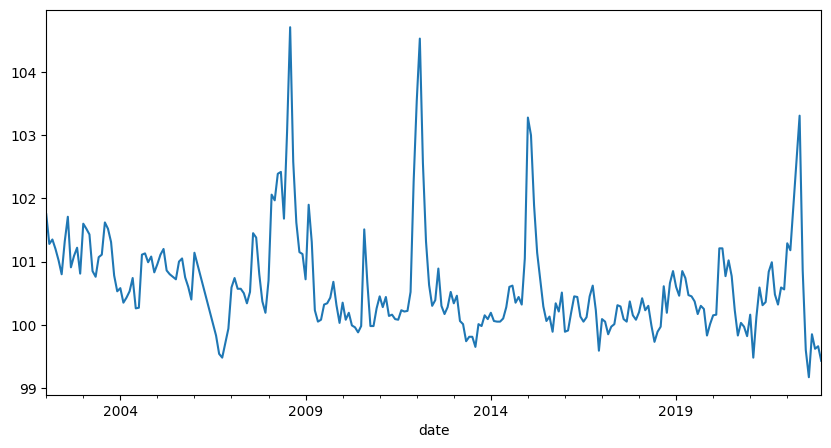

In [1139]:

data.salt = data.salt.interpolate(method='linear')

data.salt.plot(figsize=(10, 5))

In [1140]:
from statsmodels.tsa.stattools import adfuller

adfuller(data.salt)[1].round(4)

0.0

Поскольку оснований недостаточно для того, чтобы утверждать о том, что ряд нестационарен, можем говорить об отстутствии линейного тренда

In [1141]:
model = sm.OLS(data.salt, sm.add_constant(np.arange(data.shape[0]))).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   salt   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     20.03
Date:                Thu, 15 Feb 2024   Prob (F-statistic):           1.16e-05
Time:                        23:25:25   Log-Likelihood:                -291.27
No. Observations:                 252   AIC:                             586.5
Df Residuals:                     250   BIC:                             593.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        101.0018      0.097   1041.886      0.0

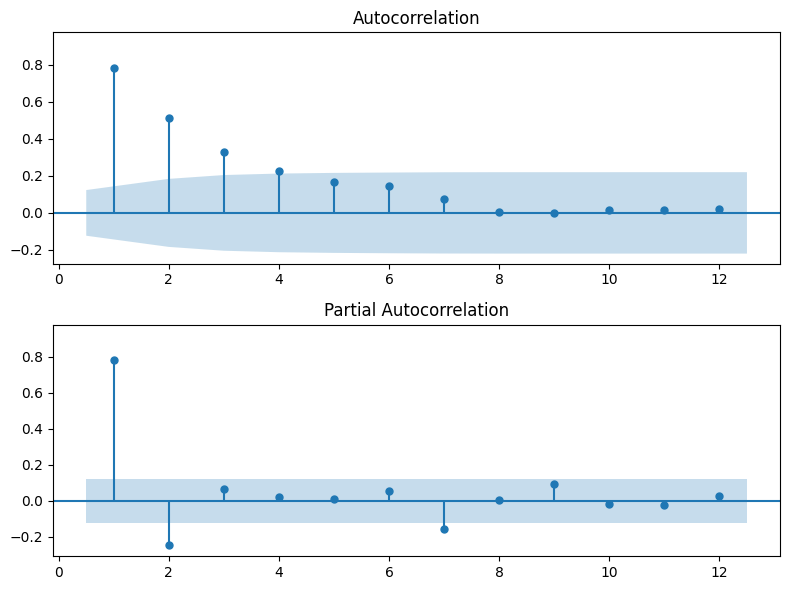

In [1142]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
plot_acf(data.salt,lags=12, ax=ax[0], zero=False, auto_ylims=True)
plot_pacf(data.salt,lags=12, ax=ax[1], zero=False, auto_ylims=True)

plt.tight_layout()
plt.show()

In [1143]:
data['time'] = np.arange(data.shape[0])
data.columns = ['y', 'x']

In [1144]:
def chow_test(dataframe, split):
    # Разделите данные на две части
    sample1 = dataframe.iloc[:split]
    sample2 = dataframe.iloc[split:]

    # Постройте модель OLS для каждого образца
    model1 = sm.OLS(sample1['y'], sm.add_constant(sample1['x'])).fit()
    model2 = sm.OLS(sample2['y'], sm.add_constant(sample2['x'])).fit()

    # Постройте модель OLS для всего набора данных
    model3 = sm.OLS(dataframe['y'], sm.add_constant(dataframe['x'])).fit()

    # Вычислите статистику Чоу
    num = (model3.ssr - (model1.ssr + model2.ssr)) / 2
    den = (model1.ssr + model2.ssr) / (sample1.shape[0] + sample2.shape[0] - 4)
    F = num / den

    # Вычислите p-значение
    p_value = 1 - stats.f.cdf(F, 2, sample1.shape[0] + sample2.shape[0] - 4)

    return F, p_value, [model1, model2, model3]

In [1145]:
result = {}
for i in range(20, data.shape[0]-20):
    result[i] = chow_test(data, i)[:-1]

result = pd.DataFrame(result).T

result.columns = ['F', 'p-value']

result.sort_values(by='F', ascending=False).round(4).head(30)

,F,p-value
87,6.4292,0.0019
86,5.7883,0.0035
88,5.7239,0.0037
67,5.5601,0.0043
66,5.4797,0.0047
60,5.2914,0.0056
61,5.2624,0.0058
65,5.1772,0.0063
64,5.0770,0.0069
63,5.0651,0.0070


In [1146]:
f, p_value, models = chow_test(data, 87)

print(f, p_value)

6.429247017755617 0.001895791470839736


<Axes: xlabel='date'>

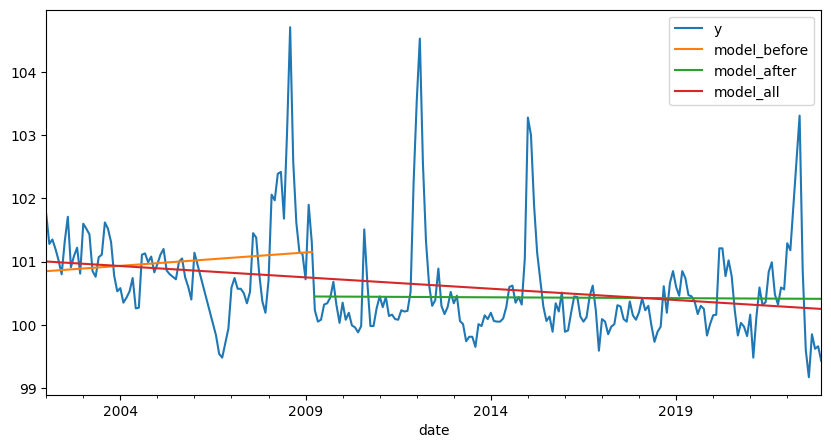

In [1147]:
model_before, model_after, model_all = models[0], models[1], models[2]
data_chow = data.drop(columns=['x'])
data_chow['model_before'], data_chow['model_after'], data_chow['model_all'] = model_before.fittedvalues, model_after.fittedvalues, model_all.fittedvalues
data_chow.plot(figsize=(10, 5))

In [1148]:
f, p_value, models = chow_test(data, 67)

print(f, p_value)

5.560061599298271 0.004343770564687599


In [1149]:
print(models[0].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     50.60
Date:                Thu, 15 Feb 2024   Prob (F-statistic):           1.09e-09
Time:                        23:25:27   Log-Likelihood:                -28.386
No. Observations:                  67   AIC:                             60.77
Df Residuals:                      65   BIC:                             65.18
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        101.3542      0.091   1117.771      0.0

In [1150]:
print(models[1].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     11.68
Date:                Thu, 15 Feb 2024   Prob (F-statistic):           0.000777
Time:                        23:25:27   Log-Likelihood:                -232.22
No. Observations:                 185   AIC:                             468.4
Df Residuals:                     183   BIC:                             474.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        101.2031      0.197    513.420      0.0

<Axes: xlabel='date'>

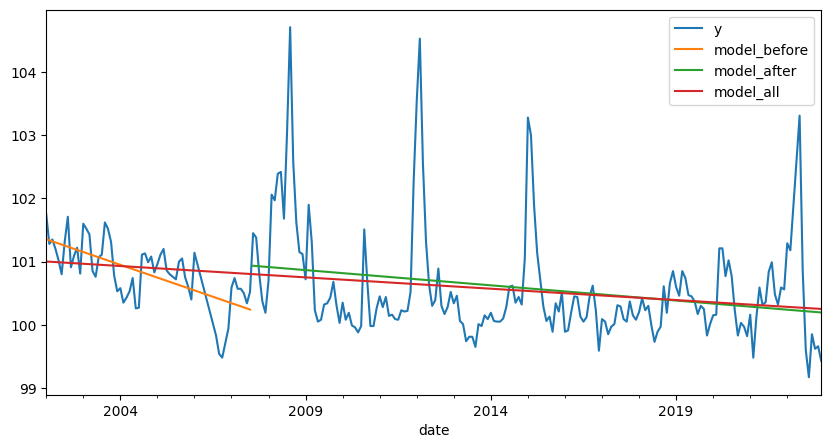

In [1151]:
model_before, model_after, model_all = models[0], models[1], models[2]
data_chow = data.drop(columns=['x'])
data_chow['model_before'], data_chow['model_after'], data_chow['model_all'] = model_before.fittedvalues, model_after.fittedvalues, model_all.fittedvalues
data_chow.plot(figsize=(10, 5))

In [1152]:
data['structural_shift_1'] = ((data.index >= '2002-01-01') & (data.index < '2006-10-01')).astype(int)
data['structural_shift_2'] = ((data.index >= '2006-10-01') & (data.index < '2009-05-01')).astype(int)
data['structural_shift_3'] = ((data.index >= '2009-05-01') & (data.index < '2017-01-01')).astype(int)
data['structural_shift_4'] = ((data.index >= '2017-01-01') & (data.index < '2020-11-01')).astype(int)
data['structural_shift_5'] = ((data.index >= '2020-11-01') & (data.index < '2022-06-01')).astype(int)

In [1153]:
data

,y,x,structural_shift_1,structural_shift_2,structural_shift_3,structural_shift_4,structural_shift_5
date,,,,,,,
2002-01-01,101.75,0,1,0,0,0,0
2002-02-01,101.28,1,1,0,0,0,0
2002-03-01,101.35,2,1,0,0,0,0
2002-04-01,101.20,3,1,0,0,0,0
2002-05-01,101.02,4,1,0,0,0,0
...,...,...,...,...,...,...,...
2022-08-01,99.17,247,0,0,0,0,0
2022-09-01,99.85,248,0,0,0,0,0
2022-10-01,99.62,249,0,0,0,0,0


In [1154]:
from statsmodels.formula.api import ols

model = ols(
    'y ~ x + I(structural_shift_1*x) + structural_shift_2*x + structural_shift_3*x + structural_shift_4*x + structural_shift_5*x',
    data=data
).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     11.91
Date:                Thu, 15 Feb 2024   Prob (F-statistic):           1.19e-16
Time:                        23:25:28   Log-Likelihood:                -250.40
No. Observations:                 252   AIC:                             522.8
Df Residuals:                     241   BIC:                             561.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

<Axes: xlabel='date'>

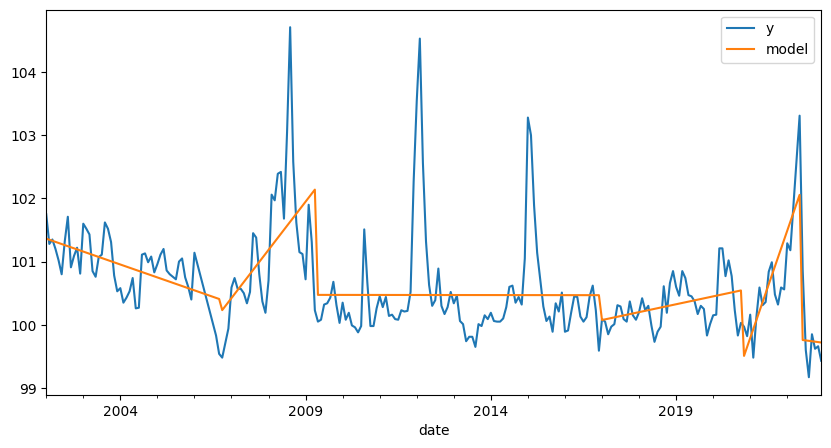

In [1155]:
data['model'] = model.fittedvalues

data[['y', 'model']].plot(figsize=(10, 5))